Script to average kelp measurements onto same grid as MUR data

In [1]:
import os
import glob
import numpy as np
import xarray as xr
from tqdm import tqdm
from scipy.interpolate import interp1d
from joblib import dump

r_earth = 6371.0 # km

kelp_file = "../Data/LandsatKelpBiomass_2023_Q3_withmetadata.nc"
kelp = xr.open_dataset(kelp_file)

mur_dir = "MUR"
mur_files = glob.glob(os.path.join(mur_dir, "*MUR*.nc"))

In [2]:
# find the index closest to the kelp time
ds = xr.open_dataset(mur_files[2])
t0 = ds['time'].values #MUR
t = kelp['time'].values # kelp
idx = np.argmin(np.abs(t - t0))

print(f"MUR time: {t0}")
print(f"Closest kelp index: {idx}")
print(f"Closest time: {t[idx]}")

mask = t == t[idx]

MUR time: ['2002-08-15T21:00:00.000000000']
Closest kelp index: 74
Closest time: 2002-08-15T00:00:00.000000000


In [3]:
def process_location(lat, lon, kelp):
    # average kelp area within 0.01 degrees of the lat/lon

    location_data = {
        'lat': lat,
        'long': lon,
        'mur_time': [],
        'mur_temp': [],
        'mur_temp_std': [],
        'kelp_area': [], # m^2 per km^2
        'kelp_time': kelp.time.values,
    }

    mask = (kelp.latitude >= lat - 0.005) & (kelp.latitude < lat + 0.005) & \
           (kelp.longitude >= lon - 0.005) & (kelp.longitude < lon + 0.005)

    if not kelp.time.values.size:  # Check if 'kelp_time' is empty
        return None

    if not np.any(mask) or np.all(np.isnan(kelp.area.values[:, mask])):
        return None
    
    # calculate the area of the grid cell adjust for latitude
    scale_factor = r_earth * np.pi / 180.0  * np.abs(np.cos(np.deg2rad(lat))) # km per degree
    area = (scale_factor * 0.01 * 1000)**2 # meters squared
    location_data['kelp_area'] = np.nansum(kelp.area.values[:, mask],axis=1) # total surface area [m^2]
    location_data['kelp_area'] = location_data['kelp_area'] / area * 1000**2 # m^2 per km^2

    return location_data

In [4]:
print("Reading and processing data...")
ds = xr.open_dataset(mur_files[2])
lat_grid = ds.lat.values
lon_grid = ds.lon.values
ds.close()

# Find the minimum and maximum latitude and longitude values from the kelp dataset
min_lat, max_lat = kelp.latitude.min().values, kelp.latitude.max().values
min_lon, max_lon = kelp.longitude.min().values, kelp.longitude.max().values

# Filter the lat_grid and lon_grid arrays to include only the values within the kelp's latitude and longitude range
lat_mask = (lat_grid >= min_lat) & (lat_grid <= max_lat)
lon_mask = (lon_grid >= min_lon) & (lon_grid <= max_lon)
lat_grid = lat_grid[lat_mask]
lon_grid = lon_grid[lon_mask]

downscaled_kelp = np.zeros((len(lat_grid), len(lon_grid)))

print("Extracting kelp data...")
for i in tqdm(enumerate(lat_grid), total=len(lat_grid)):
    lat = i[1]
    for j,lon in enumerate(lon_grid):
        location_data = process_location(lat, lon, kelp)
        if location_data is not None:

            # extract kelp at that particular time
            downscaled_kelp[i[0], j] = location_data['kelp_area'][idx]

Reading and processing data...
Extracting kelp data...


100%|██████████| 2139/2139 [24:27<00:00,  1.46it/s]


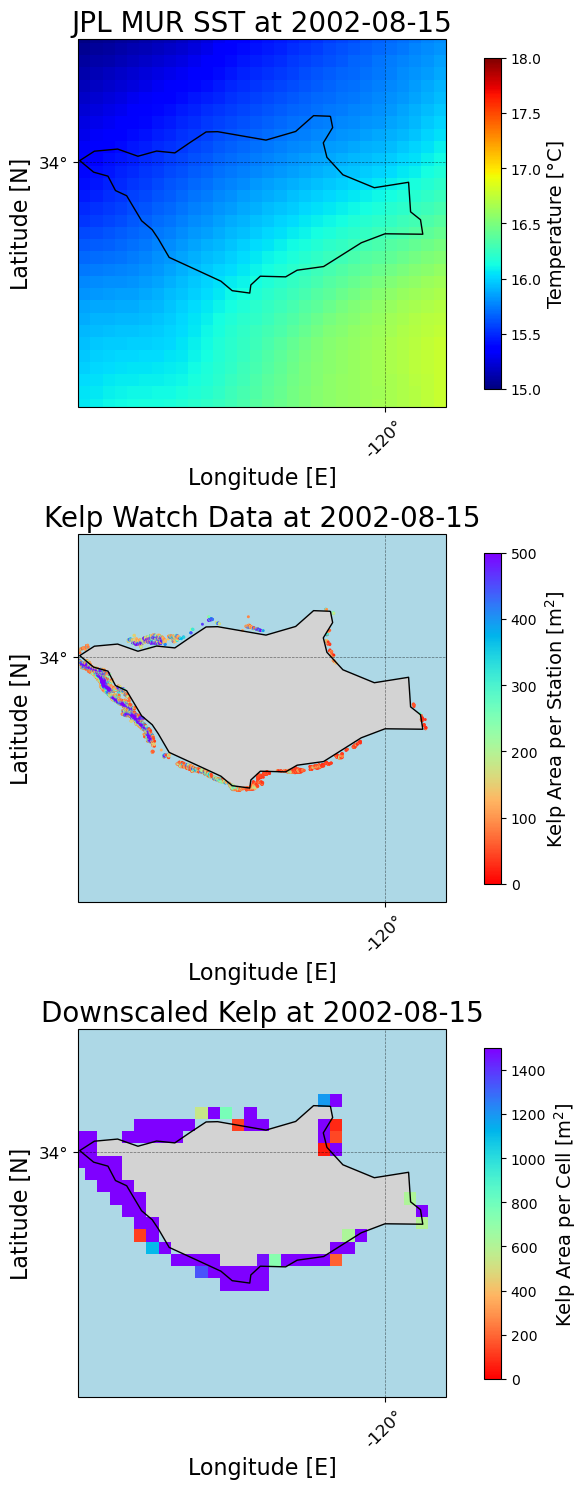

In [5]:
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# set up the figure with 3 subplots
fig = plt.figure(figsize=(8,15))

datestr = str(t[idx]).split('T')[0]

ax0 = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
ax0.set_title(f"JPL MUR SST at {datestr}", fontsize=20)

ax1 = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
ax1.set_title(f"Kelp Watch Data at {datestr}", fontsize=20)

ax2 = fig.add_subplot(3, 1, 3, projection=ccrs.PlateCarree())
ax2.set_title(f"Downscaled Kelp at {datestr}", fontsize=20)

axs = [ax0, ax1, ax2]
for ax in axs:

    # draw the map
    ax.coastlines()
    ax.set_global()
    # set title with datetime
    ax.add_feature(cartopy.feature.LAND, facecolor='lightgray')
    ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')

    ax.set_xticks(np.arange(-180, 180, 2), crs=ccrs.PlateCarree())
    ax.set_xticklabels([f'{x}°' for x in np.arange(-180, 180, 2)], fontsize=12, rotation=45)
    ax.set_yticks(np.arange(-90, 90, 2), crs=ccrs.PlateCarree())
    ax.set_yticklabels([f'{x}°' for x in np.arange(-90, 90, 2)], fontsize=12)

    ax.set_xlabel(f'Longitude [E]', fontsize=16)
    ax.set_ylabel(f'Latitude [N]', fontsize=16)
    ax.grid(True,color='k', alpha=0.5, linestyle='--', linewidth=0.5)

    # zoom in on the bounding box
    #ax.set_extent([-124, -112, 26, 40], crs=ccrs.PlateCarree())
    clat = 33.95
    clon = -120.1
    bs = 0.15
    ax.set_extent([clon-bs, clon+bs, clat-bs, clat+bs], crs=ccrs.PlateCarree())

# temperature
im = ax0.imshow(ds['monthly_mean_sst'].values[0]-273.15, origin='lower', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree(), cmap='jet', interpolation='none', vmin=15, vmax=18)
cbar = plt.colorbar(im, ax=ax0, shrink=0.9, orientation='vertical')
cbar.set_label('Temperature [°C]', fontsize=14)

# kelp raw
kelp_lat = kelp['latitude'].values
kelp_lon = kelp['longitude'].values

area_mask = (kelp_lat >= clat - bs) & (kelp_lat < clat + bs) & \
            (kelp_lon >= clon - bs) & (kelp_lon < clon + bs)

kelp_area = kelp['area'].values[idx][area_mask]

non_zero_mask = (kelp_area > 0)

im = ax1.scatter(kelp_lon[area_mask][non_zero_mask], kelp_lat[area_mask][non_zero_mask], c=kelp_area[non_zero_mask], marker='.', label="Kelp Area", transform=ccrs.PlateCarree(), cmap='rainbow_r',vmin=0,vmax=500, s=5)
cbar = plt.colorbar(im, ax=ax1, shrink=0.9, orientation='vertical')
cbar.set_label('Kelp Area per Station [m$^2$]', fontsize=14)

# kelp downscaled
downscaled_kelp[downscaled_kelp == 0] = np.nan

im = ax2.imshow(downscaled_kelp, origin='lower', extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()], transform=ccrs.PlateCarree(), cmap='rainbow_r', interpolation='none', vmin=0, vmax=1500)
cbar = plt.colorbar(im, ax=ax2, shrink=0.9, orientation='vertical')
cbar.set_label('Kelp Area per Cell [m$^2$]', fontsize=14)

plt.tight_layout()
plt.show()

In [13]:
# slice the mur data around that region
lat_mask = (ds.lat >= clat - bs) & (ds.lat < clat + bs)
lon_mask = (ds.lon >= clon - bs) & (ds.lon < clon + bs)
sds = ds.sel(lat=lat_mask, lon=lon_mask)
dtemp = sds['monthly_mean_sst'].values[0]

lat_min = sds.lat.values.min()
lat_max = sds.lat.values.max()
lon_min = sds.lon.values.min()
lon_max = sds.lon.values.max()

# compute the gradient of the temperature
grad = np.gradient(dtemp)
grad = np.sqrt(grad[0]**2 + grad[1]**2)

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(grad, origin='lower', cmap='hot', interpolation='none', vmin=0, vmax=0.1, extent=[lon_min, lon_max, lat_min, lat_max])
cbar = plt.colorbar(im, ax=ax, shrink=0.9, orientation='vertical')
cbar.set_label('Temperature Gradient [°C/cell]', fontsize=14)
ax.set_xlabel('Longitude [E]', fontsize=16)
ax.set_ylabel('Latitude [N]', fontsize=16)
ax.set_title('Temperature Gradient', fontsize=20)
plt.show()



IndexError: boolean index did not match indexed array along dimension 0; dimension is 30 but corresponding boolean dimension is 17999

In [15]:
sds.lat.shape

(30,)

In [9]:
(sds['monthly_mean_sst']-273.15).shape

(1, 30, 30)

In [ ]:
dfile = "20020607090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"
ds = xr.open_dataset(dfile)